In [1]:
#!pip install scikit-fuzzy   #uncomment if needed
#!pip install xgboost

# Importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import skfuzzy as fuzz
import statsmodels.api as sm

from sklearn.preprocessing import MinMaxScaler, LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import auc, roc_curve
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from matplotlib.colors import LinearSegmentedColormap

# Define a custom palette to use in notebook
custom_palette = sns.color_palette(["#124067","#0ea599", "#e1b510", "#de7b02", "#1f5d4d"])
custom_cmap = LinearSegmentedColormap.from_list(None, [custom_palette[1], "white", custom_palette[2]]) # define custom colormap

In [2]:
# Load the cleaned dataset

data = pd.read_csv("aes22_v3_cleaned.csv")
data.head()

,state,political_interest,vote_if_not_compulsory,party_id,party_support_strength,care_who_wins,party_cares_about_people,parties_needed,satisfaction_democracy,gov_for_people,...,spend_ndis,spend_transport,spend_childcare,gender,social_class,residence_type,household_income,age_group,has_uni_degree,first_pref_vote
0,5,2.0,1.0,2.0,2,1.0,2.0,2.0,2.0,3.0,...,2.0,2.0,2.0,1.0,3.0,5.0,3.0,3.0,1.0,2.0
1,5,2.0,2.0,3.0,4,2.0,4.0,2.0,2.0,3.0,...,3.0,3.0,4.0,1.0,3.0,2.0,5.0,4.0,2.0,1.0
2,5,1.0,1.0,1.0,1,1.0,2.0,2.0,2.0,2.0,...,2.0,2.0,3.0,1.0,2.0,5.0,4.0,3.0,1.0,1.0
3,5,1.0,1.0,1.0,3,1.0,2.0,1.0,2.0,3.0,...,2.0,3.0,3.0,2.0,2.0,4.0,5.0,4.0,2.0,2.0
4,5,1.0,1.0,1.0,2,1.0,3.0,1.0,1.0,3.0,...,3.0,3.0,3.0,1.0,3.0,1.0,4.0,4.0,2.0,1.0


# 2. Data Preparation for Clustering and Modelling

## 2.1. Select Relevant Features

In [3]:
# Sub-setting data for clustering by themes
# Demographics
dem = data[['gender', 'social_class','residence_type', 'household_income', 
            'age_group', 'has_uni_degree','first_pref_vote']]
# Political engagement and attitudes
pol = data[['political_interest', 'vote_if_not_compulsory', 'party_id','party_support_strength', 
            'care_who_wins','party_cares_about_people', 'parties_needed', 'satisfaction_democracy',
            'gov_for_people', 'first_pref_vote']]
# Government spending (likert scale)
iss = data[['spend_health','spend_education', 'spend_unemployment', 
            'spend_defence','spend_pensions', 'spend_industry', 'spend_police', 
            'spend_ndis','spend_transport', 'spend_childcare', 'first_pref_vote']]
# Important issues (categorical)
iss2 = data[['top_issue', 'second_issue']]

In [4]:
# Assign features and target variable for modelling
X = data.drop(columns=['first_pref_vote', 'party_id'])
y = data['first_pref_vote']

## 2.2. Encode Categorical Variables

In [5]:
# One-hot encoding of iss2 for clustering analysis
iss2 = pd.get_dummies(iss2, columns=['top_issue', 'second_issue'], drop_first=True)
iss2.head()

,top_issue_2.0,top_issue_3.0,top_issue_4.0,top_issue_6.0,top_issue_7.0,top_issue_8.0,top_issue_10.0,top_issue_11.0,top_issue_12.0,top_issue_13.0,second_issue_2.0,second_issue_3.0,second_issue_4.0,second_issue_6.0,second_issue_7.0,second_issue_8.0,second_issue_10.0,second_issue_11.0,second_issue_12.0,second_issue_13.0
0,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
2,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
4,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False


In [6]:
iss2.shape

(2430, 20)

## 2.3. Standardize the Data

In [7]:
# Use MinMaxScalar to scale data to range [0,1]
scaler = MinMaxScaler()

# Scale data subsets
dem_sc = scaler.fit_transform(dem)
pol_sc = scaler.fit_transform(pol)
iss_sc = scaler.fit_transform(iss)

# 3. Clustering Analysis with Fuzzy C-means clustering

Fuzzy C-means was selected as is well-suited to this dataset. Data points in the fuzzy c-means algorithm can belong to more than one cluster with a likelihood (membership confidence value). As a result, fuzzy c-means clustering gives comparatively better results for overlapped data sets like in social science contexts where group boundaries are often blurry.

## 3.1. Demographics

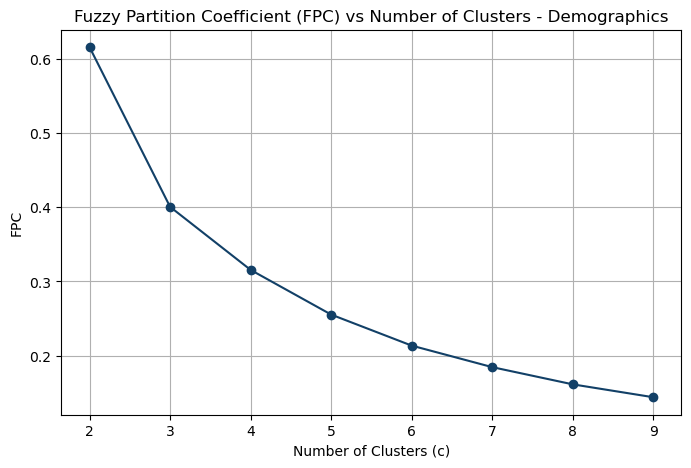

In [8]:
# Range of cluster numbers to test
cluster_range = range(2, 10)  # Test clusters from 2 to 9
fpc_scores = []

for c in cluster_range:
    cntr, u,_,_,_,_,fpc = fuzz.cluster.cmeans(
        dem_sc.T, c=c, m=2, error=0.005, maxiter=1000, init=None, seed=42
    )
    fpc_scores.append(fpc)

# Plot FPC scores
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, fpc_scores, marker='o', color=custom_palette[0])
plt.title('Fuzzy Partition Coefficient (FPC) vs Number of Clusters - Demographics')
plt.xlabel('Number of Clusters (c)')
plt.ylabel('FPC')
plt.grid(True)
plt.show()

Note: Two clusters provide the best separation

In [9]:

# Apply fuzzy c-means with best number of clusters
cntr_dem, u_dem,_,_,_,_,fpc_dem = fuzz.cluster.cmeans(
    dem_sc.T, c=2, m=2, error=0.005, maxiter=1000, init=None, seed=42
)

# Hard cluster assignments
labels = np.argmax(u_dem, axis=0)

# Convert scaled array to a DataFrame first
dem_sc_with_labels = pd.DataFrame(dem_sc, columns=dem.columns)

# Add cluster labels as a new column
dem_sc_with_labels['cluster'] = labels

print(f"Fuzzy Partition Coefficient (FPC): {fpc_dem:.3f}")

# Count the number of samples in each cluster
dem_counts = pd.Series(labels).value_counts().sort_index()
print("\nNumber of samples in each cluster:")
for cluster, count in dem_counts.items():
    print(f"Cluster {cluster}: {count}")


Fuzzy Partition Coefficient (FPC): 0.616

Number of samples in each cluster:
Cluster 0: 1298
Cluster 1: 1132


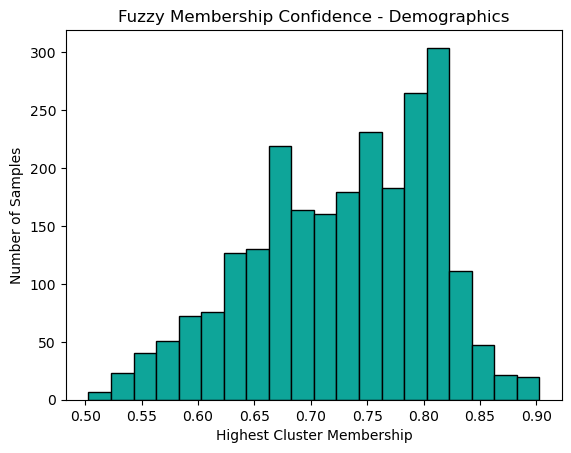

In [10]:
# Visualize maximum membership confidence values
max_membership = u_dem.max(axis=0)  # max membership value for each sample
plt.hist(max_membership, bins=20, color=custom_palette[1], edgecolor='black')
plt.title("Fuzzy Membership Confidence - Demographics")
plt.xlabel("Highest Cluster Membership")
plt.ylabel("Number of Samples")
plt.show()


In [11]:
# checking feature means per cluster to understand the clusters
dem_cluster_prof = dem_sc_with_labels.groupby('cluster').mean(numeric_only=True)
display(dem_cluster_prof.T)


cluster,0,1
gender,0.264638,0.267668
social_class,0.543400,0.419317
residence_type,0.732666,0.826855
household_income,0.463020,0.623012
age_group,0.815100,0.675501
has_uni_degree,1.000000,0.000883
first_pref_vote,0.389445,0.525177


## 3.2. Political engagement and attitudes

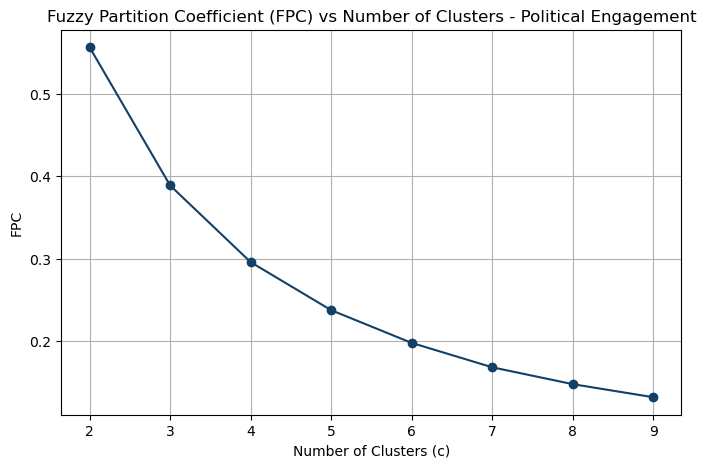

In [12]:
# Range of cluster numbers to test
cluster_range = range(2, 10)  # Test clusters from 2 to 9
fpc_scores = []

for c in cluster_range:
    cntr, u,_,_,_,_,fpc = fuzz.cluster.cmeans(
        pol_sc.T, c=c, m=2, error=0.005, maxiter=1000, init=None, seed=42
    )
    fpc_scores.append(fpc)

# Plot FPC scores
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, fpc_scores, marker='o', color=custom_palette[0])
plt.title('Fuzzy Partition Coefficient (FPC) vs Number of Clusters - Political Engagement')
plt.xlabel('Number of Clusters (c)')
plt.ylabel('FPC')
plt.grid(True)
plt.show()

Note: Two clusters also provide the best separation

In [13]:

# Apply fuzzy c-means with best number of clusters
cntr_pol, u_pol,_,_,_,_,fpc_pol = fuzz.cluster.cmeans(
    pol_sc.T, c=2, m=2, error=0.005, maxiter=1000, init=None, seed=42
)

# Hard cluster assignments
labels = np.argmax(u_pol, axis=0)

# Convert scaled array to a DataFrame first
pol_sc_with_labels = pd.DataFrame(pol_sc, columns=pol.columns)

# Add cluster labels as a new column
pol_sc_with_labels['cluster'] = labels

print(f"Fuzzy Partition Coefficient (FPC): {fpc_pol:.3f}")

# Count the number of samples in each cluster
pol_counts = pd.Series(labels).value_counts().sort_index()
print("\nNumber of samples in each cluster:")
for cluster, count in pol_counts.items():
    print(f"Cluster {cluster}: {count}")


Fuzzy Partition Coefficient (FPC): 0.556

Number of samples in each cluster:
Cluster 0: 1164
Cluster 1: 1266


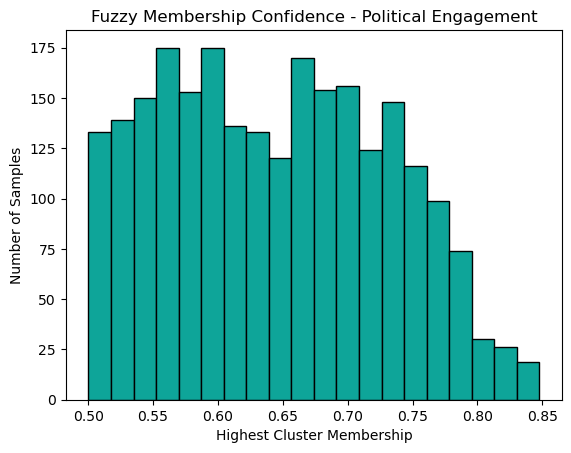

In [14]:
# Visualize maximum membership confidence values
max_membership = u_pol.max(axis=0)  # max membership value for each sample
plt.hist(max_membership, bins=20, color=custom_palette[1], edgecolor='black')
plt.title("Fuzzy Membership Confidence - Political Engagement")
plt.xlabel("Highest Cluster Membership")
plt.ylabel("Number of Samples")
plt.show()


In [15]:
# checking feature means per cluster to understand the clusters
pol_cluster_prof = pol_sc_with_labels.groupby('cluster').mean(numeric_only=True)
display(pol_cluster_prof.T)


cluster,0,1
political_interest,0.296678,0.200369
vote_if_not_compulsory,0.169244,0.071485
party_id,0.777491,0.160742
party_support_strength,0.599370,0.321748
care_who_wins,0.198454,0.108610
party_cares_about_people,0.623711,0.500395
parties_needed,0.358462,0.177133
satisfaction_democracy,0.444731,0.329384
gov_for_people,0.309708,0.458531
first_pref_vote,0.721220,0.205766


## 3.3. Government spending

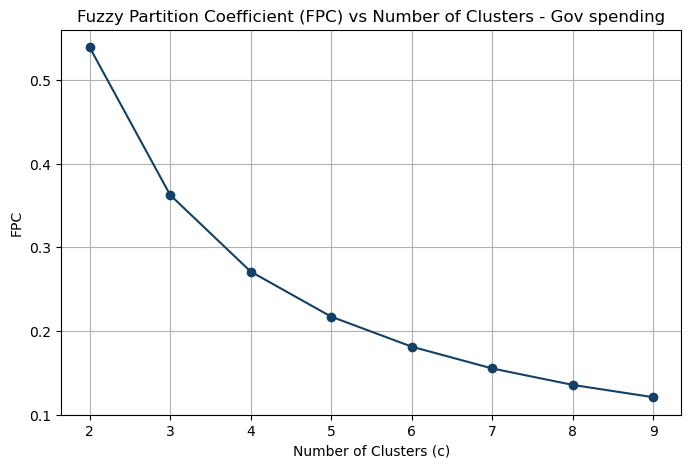

In [16]:
# Range of cluster numbers to test
cluster_range = range(2, 10)  # Test clusters from 2 to 9
fpc_scores = []

for c in cluster_range:
    cntr, u,_,_,_,_,fpc = fuzz.cluster.cmeans(
        iss_sc.T, c=c, m=2, error=0.005, maxiter=1000, init=None, seed=42
    )
    fpc_scores.append(fpc)

# Plot FPC scores
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, fpc_scores, marker='o', color=custom_palette[0])
plt.title('Fuzzy Partition Coefficient (FPC) vs Number of Clusters - Gov spending')
plt.xlabel('Number of Clusters (c)')
plt.ylabel('FPC')
plt.grid(True)
plt.show()

In [17]:

# Apply fuzzy c-means with best number of clusters
cntr_iss, u_iss,_,_,_,_,fpc_iss = fuzz.cluster.cmeans(
    iss_sc.T, c=2, m=2, error=0.005, maxiter=1000, init=None, seed=42
)

# Hard cluster assignments
labels = np.argmax(u_iss, axis=0)

# Convert scaled array to a DataFrame first
iss_sc_with_labels = pd.DataFrame(iss_sc, columns=iss.columns)

# Add cluster labels as a new column
iss_sc_with_labels['cluster'] = labels

print(f"Fuzzy Partition Coefficient (FPC): {fpc_iss:.3f}")

# Count the number of samples in each cluster
iss_counts = pd.Series(labels).value_counts().sort_index()
print("\nNumber of samples in each cluster:")
for cluster, count in iss_counts.items():
    print(f"Cluster {cluster}: {count}")


Fuzzy Partition Coefficient (FPC): 0.539

Number of samples in each cluster:
Cluster 0: 1254
Cluster 1: 1176


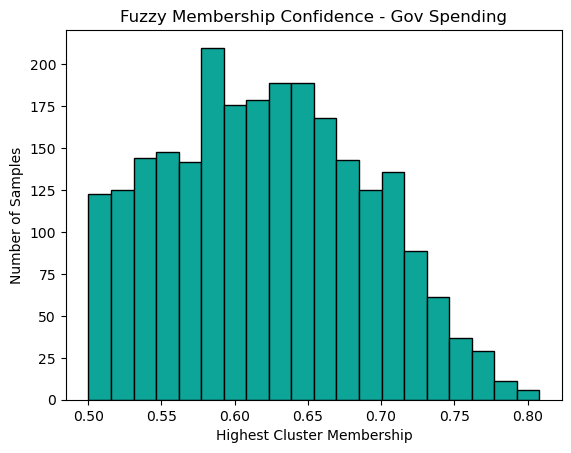

In [18]:
# Visualize maximum membership confidence values
max_membership = u_iss.max(axis=0)  # max membership value for each sample
plt.hist(max_membership, bins=20, color=custom_palette[1], edgecolor='black')
plt.title("Fuzzy Membership Confidence - Gov Spending")
plt.xlabel("Highest Cluster Membership")
plt.ylabel("Number of Samples")
plt.show()


In [19]:
# checking feature means per cluster to understand the clusters
iss_cluster_prof = iss_sc_with_labels.groupby('cluster').mean(numeric_only=True)
display(iss_cluster_prof.T)


cluster,0,1
spend_health,0.153309,0.259991
spend_education,0.187600,0.333971
spend_unemployment,0.313796,0.562925
spend_defence,0.482855,0.303571
spend_pensions,0.249801,0.326318
spend_industry,0.502392,0.442815
spend_police,0.426236,0.331633
spend_ndis,0.277313,0.461522
spend_transport,0.282895,0.402636
spend_childcare,0.289274,0.492772


## 3.4. Important issues to voters


In [20]:

# Apply fuzzy c-means with same number of clusters as issues of concern - likert scale
cntr_iss2, u_iss2,_,_,_,_,fpc_iss2 = fuzz.cluster.cmeans(
    iss2.T, c=2, m=2, error=0.005, maxiter=1000, init=None, seed=42
)

# Hard cluster assignments
labels = np.argmax(u_iss2, axis=0)

# Convert scaled array to a DataFrame first
iss2_with_labels = pd.DataFrame(iss2, columns=iss2.columns)

# Add cluster labels as a new column
iss2_with_labels['cluster'] = labels

print(f"Fuzzy Partition Coefficient (FPC): {fpc_iss2:.3f}")

# Count the number of samples in each cluster
iss2_counts = pd.Series(labels).value_counts().sort_index()
print("\nNumber of samples in each cluster:")
for cluster, count in iss2_counts.items():
    print(f"Cluster {cluster}: {count}")


Fuzzy Partition Coefficient (FPC): 0.500

Number of samples in each cluster:
Cluster 0: 866
Cluster 1: 1564


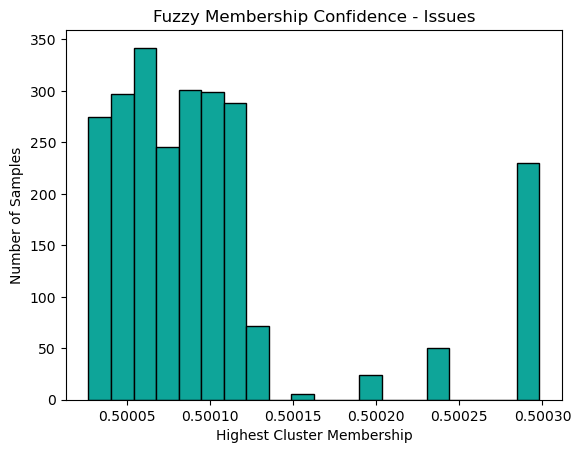

In [21]:
# Visualize maximum membership confidence values
max_membership = u_iss2.max(axis=0)  # max membership value for each sample
plt.hist(max_membership, bins=20, color=custom_palette[1], edgecolor='black')
plt.title("Fuzzy Membership Confidence - Issues")
plt.xlabel("Highest Cluster Membership")
plt.ylabel("Number of Samples")
plt.show()


In [22]:
# checking feature means per cluster to understand the clusters
iss2_cluster_prof = iss2_with_labels.groupby('cluster').mean(numeric_only=True)
display(iss2_cluster_prof.T)


cluster,0,1
top_issue_2.0,0.005774,0.031969
top_issue_3.0,0.018476,0.057545
top_issue_4.0,0.049654,0.102941
top_issue_6.0,0.006928,0.163683
top_issue_7.0,0.003464,0.015985
top_issue_8.0,0.086605,0.200128
top_issue_10.0,0.110855,0.216113
top_issue_11.0,0.015012,0.036445
top_issue_12.0,0.661663,0.000000
top_issue_13.0,0.013857,0.075448


## 3.3. Cluster Comparison and Interpretation

In all data subsets, two clusters were identified. Fuzzy Partition Coefficients (FPC) were moderate, with lowest value of 0.50 (issues - categorical variables) and highest value of 0.62 (demographics). This suggests that there is significant overlap between clusters, but the clusters are not completely indistinguishable. Data points may have partial membership in multiple clusters, which is expected in fuzzy clustering. The clusters are not perfectly distinct, but there is still some structure in the data that the algorithm has captured. This is quite common when analysing survey data or behavioural data.

**Demographics clusters**: Membership Confidence skewed towards higher values with most of them between 0.68 and 0.82.
- Cluster 0 (1298 samples): This group is largely made up of older voters living in smaller towns or rural areas. They tend to have lower incomes, no university qualifications, and are more likely to identify as working class. Voters in this cluster showed stronger support for the Coalition.

- Cluster 1 (1132 samples): This cluster primarily consists of younger, urban voters with higher incomes and university degrees. They are more likely to identify as middle class and tended to vote for Labor or Other parties.

**Political engagement and attitudes clusters:**: Membership Confidence is bimodal, with most values between 0.50 and 0.58 or between 0.67 and 0.76.
- Cluster 0 (1164 samples): This group consists mostly of voters who identify as moderate to strong supporters of Labor or Other parties. They tend to believe that political parties do not care much about ordinary people and are less likely than Cluster 1 voters to see political parties as essential to democracy.

- Cluster 1 (1266 samples): This cluster is primarily made up of moderate Coalition supporters. Compared to Cluster 0, they report higher satisfaction with democracy, stronger belief in the importance of political parties, and are more likely to feel that parties care about the public.

**Government spending clusters:** Membership Confidence skewed towards lower values with most of them between 0.58 and 0.70.
- Cluster 0 (1254 samples): Voters in this group favour increased government spending on social services such as health, education, unemployment benefits, the NDIS, and childcare. They were more likely to vote for Labor or Other parties.

- Cluster 1 (1176 samples): This cluster prefers greater government investment in areas like defence, police, and business and industry. These voters showed stronger support for the Coalition.

**Important issues to voters clusters:** Membership Confidence values are all around 0.5. These are the clusters with the most overlaps.
- Cluster 0 (866 samples): Voters in this group are primarily concerned with cost of living, health, and Medicare. Their priorities tend to focus on immediate, day-to-day issues.

- Cluster 1 (1564 samples): This cluster is more focused on broader or long-term concerns such as global warming and the economy, while also ranking cost of living highly. Compared to Cluster 0, they also place slightly more importance on issues like the environment, immigration, and asylum seekers.

Although there is considerable overlap between voter segments, the clustering results suggest broad patterns in the types of voters attracted to each party in the 2022 election:

**Voters attracted to the Coalition in the 2022 election** were more likely to be older Australians living in rural or regional areas, with lower levels of formal education and household income, and often identifying as working class. They tended to express stronger trust in the party system and greater satisfaction with the way democracy is working. These voters prioritized government investment in areas like defence, police, and business and industry, and were generally less concerned about environmental and social issues. Their issue focus leaned toward national security, economic stability, and cost of living pressures.

**Voters drawn to Labor and Other parties,** including the Greens and independents, tended to be younger, more urban, university-educated, and middle-class, with higher income levels. They were often more skeptical of political parties and more dissatisfied with the state of democracy, yet showed higher engagement in political issues. These voters supported increased public spending on health, education, the NDIS, childcare, and social safety nets. Their top concerns included global warming, the environment, and social equity, while also acknowledging economic issues like cost of living. This group represented a more progressive and socially-oriented segment of the electorate.

# 4. Modelling

## 4.1. Model 1: Multinomial Logistic Regression
Assumptions:
- target variable is unordered categorical: 1 = Coalition, 2 = Labor, 3 = Other
- feaures are independent
- there is a linear relationship between the features and the logit transformation of the target variable
- features have no outliers

In [23]:
# Split your data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Scale features
scaler = MinMaxScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

In [24]:
print("shape of training data:", X_train.shape, y_train.shape)
print("shape of test data:", X_test.shape, y_test.shape)

shape of training data: (1944, 27) (1944,)
shape of test data: (486, 27) (486,)


In [25]:
# Initialise the logistic regression model
log_model = LogisticRegression(
    solver='lbfgs',
    class_weight='balanced',
    max_iter=1000,
    random_state=42
)
# Stratified K-Folds cross-validator
cv = StratifiedKFold(5)

# Recursive feature selection
rfecv = RFECV(
    estimator=log_model,
    step=1,
    cv=cv,
    verbose=0,
    scoring='f1_weighted',
    n_jobs=2
)

rfecv.fit(X_train_sc, y_train)

RFECV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
      estimator=LogisticRegression(class_weight='balanced', max_iter=1000,
                                   random_state=42),
      n_jobs=2, scoring='f1_weighted')

In [26]:
print(f"Optimal number of features: {rfecv.n_features_}")

Optimal number of features: 26


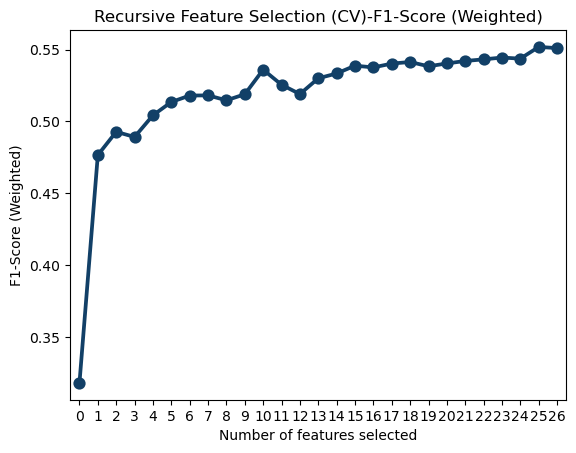

In [27]:
# Plot the CV performance
cv_results = pd.DataFrame(rfecv.cv_results_)

sns.pointplot(
    data = cv_results,
    x = range(0,27),
    y = "mean_test_score",
    errorbar = "sd",
    color=custom_palette[0]
)
plt.title("Recursive Feature Selection (CV)-F1-Score (Weighted)")
plt.xlabel('Number of features selected')
plt.ylabel("F1-Score (Weighted)")
plt.show()

In [28]:
# Doing a t-test to compare if a model with 20 features is significantly different from a model with 27 features
t, p, d = sm.stats.ttest_ind(cv_results.iloc[19][2:7], cv_results.iloc[26][2:7])
print(f"t-statistic: {t}, p-value: {p}, Cohen's d: {d}")

t-statistic: -0.8825173267148885, p-value: 0.4032350174220817, Cohen's d: 8.0


Note: p-value higher than 0.05 therefore there is no statistical difference. The model will be fitted with the 20 best features for better interpretability

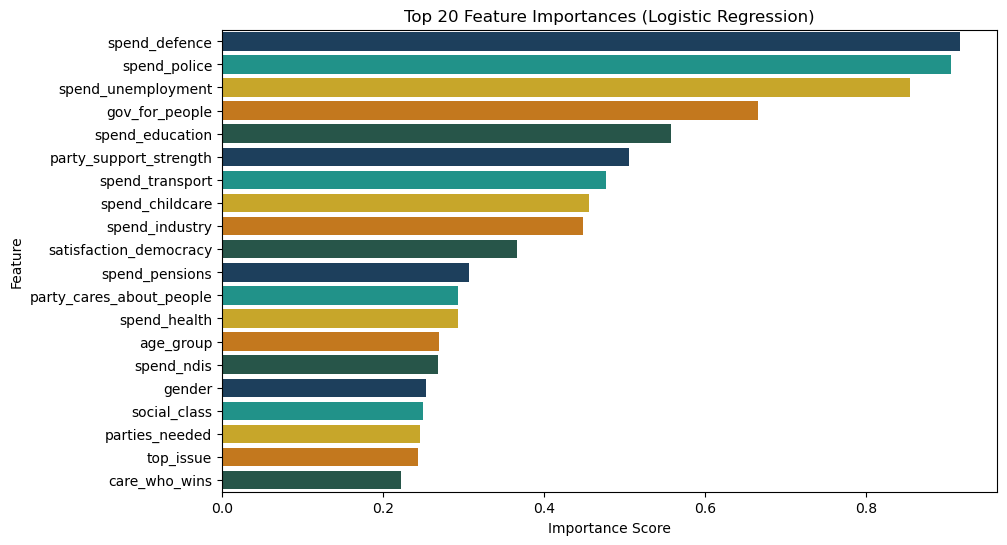

In [29]:
# Get the selected features
selected_features = X_train.columns[rfecv.support_]

# Get the coefficients of the trained logistic regression model
coefficients = rfecv.estimator_.coef_

# For multinomial logistic regression, take the mean of absolute coefficients across classes
importance = np.mean(np.abs(coefficients), axis=0)

# Combine selected features with their importance
features_with_importance = list(zip(selected_features, importance))

# Sort features by importance (descending order)
sorted_features = sorted(features_with_importance, key=lambda x: x[1], reverse=True)

# Create a DataFrame for better visualization
sorted_features_df = pd.DataFrame(sorted_features, columns=['Feature', 'Importance'])

# Plot the top 20 most important features
plt.figure(figsize=(10, 6))
sns.barplot(
    x='Importance', 
    y='Feature', 
    data=sorted_features_df.head(20), 
    palette=sns.color_palette(custom_palette, 20),  # Use a built-in palette with 20 colors
    hue='Feature',
    legend=False
)

plt.title('Top 20 Feature Importances (Logistic Regression)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

In [30]:
# Convert X_train_sc to a DataFrame with the same column names as X_train
X_train_df = pd.DataFrame(X_train_sc, columns=X_train.columns, index=X_train.index)
X_test_df = pd.DataFrame(X_test_sc, columns=X_train.columns, index=X_test.index)

# Extract the top 20 feature names from sorted_features
top_features = [feature[0] for feature in sorted_features[:20]]

# Select the corresponding columns from X_train_sc
X_train_best = X_train_df[top_features]
X_test_best = X_test_df[top_features]

In [31]:
# Fit final model
# Perform cross-validation
log_cv_scores = cross_val_score(log_model, X_train_best, y_train, cv=cv, scoring='accuracy')
print(f"Cross-validation accuracy: {log_cv_scores.mean():.3f}")

# Fit the model with best features
log_model.fit(X_train_best, y_train)

# Predict on the test set
y_pred = log_model.predict(X_test_best)

# Get the coefficients
coefficients = log_model.coef_

# Get the feature names
feature_names = top_features

# Map the numeric classes to party names
class_labels = ["Coalition", "Labor", "Other"]
party_names = [class_labels[int(cls) - 1] for cls in log_model.classes_]

# Create a DataFrame for the coefficients
coef_df = pd.DataFrame(coefficients, columns=feature_names)

coef_df['party'] = party_names 

# Set the index to the party names
coef_df.set_index('party', inplace=True)

# Transpose the DataFrame for better visualization
coef_df = coef_df.T
print(coef_df)

Cross-validation accuracy: 0.547
party                     Coalition     Labor     Other
spend_defence             -1.372834  0.422223  0.950611
spend_police              -1.358801  0.260685  1.098116
spend_unemployment         1.333159 -0.165785 -1.167374
gov_for_people             1.030877 -0.281585 -0.749292
spend_education            0.886841 -0.294062 -0.592779
party_support_strength    -0.746273  0.314603  0.431670
spend_transport            0.551413  0.182468 -0.733882
spend_childcare            0.725300 -0.718484 -0.006816
spend_industry            -0.714626  0.575919  0.138707
satisfaction_democracy    -0.066378 -0.521027  0.587405
spend_pensions            -0.236253 -0.279845  0.516098
party_cares_about_people  -0.170674 -0.238439  0.409113
spend_health               0.431713 -0.215904 -0.215809
age_group                  0.416363  0.068098 -0.484462
spend_ndis                 0.343928 -0.378380  0.034453
gender                    -0.347420  0.007703  0.339718
social_class   

Notes: The logistic regression coefficients reveal clear ideological and demographic distinctions among voter groups. Coalition voters are more likely to support increased defence and police spending, while Other voters tend to oppose such measures. Coalition supporters also prefer less welfare and education spending, and show less support for increased health and childcare funding, distinguishing them from Labor voters, who are more favorable toward investment in these areas. Coalition voters are also more trusting of government, believe parties care about ordinary people, and show stronger partisan identification, while Other voters are notably more skeptical of political parties, and less satisfied with democracy overall. Interestingly, Coalition voters are older, more likely male, and more inclined to support increased industry investment, while Labor voters are more often working class, female, and supportive of NDIS and pension spending. Other voters, in contrast, are younger, more urban, and more supportive of public transport and climate-related issues, yet they feel that parties do not represent their interests. Finally, Labor voters care the most about which party wins the election, while Coalition voters care the least, further highlighting differences in political engagement and motivation.

(For more details, see documentation)

## 4.1.1. Model 1 Evaluation

In [32]:
#print classification report
log_report = classification_report(y_test, y_pred, target_names=class_labels)
print("Classification Report (Logistic Regression):\n")
print(log_report)

Classification Report (Logistic Regression):

              precision    recall  f1-score   support

   Coalition       0.64      0.69      0.66       172
       Labor       0.61      0.44      0.51       189
       Other       0.43      0.56      0.49       125

    accuracy                           0.56       486
   macro avg       0.56      0.57      0.56       486
weighted avg       0.57      0.56      0.56       486



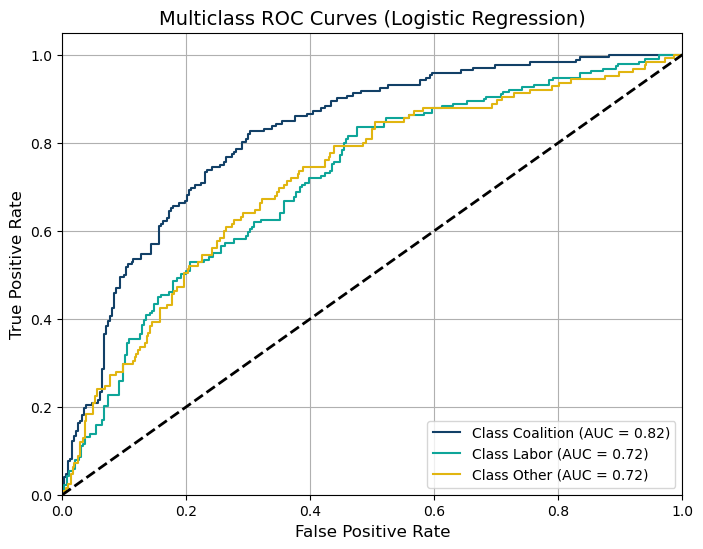

In [33]:
# predicted test probability for all clases:
y_pred_prob_all_lg = pd.DataFrame(log_model.predict_proba(X_test_best), columns=['Coalition_pp', 'Labor_pp', 'Other_pp'])

# Binarize the true labels for each class
classes = log_model.classes_  # Get the class labels
y_test_bin = label_binarize(y_test, classes=classes)  # Binarize the true labels

# Plot ROC curves for each class
plt.figure(figsize=(8, 6))
for i, class_label in enumerate(class_labels):
    # Compute ROC curve and AUC for the current class
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob_all_lg.iloc[:, i])
    roc_auc = auc(fpr, tpr)
    
    # Plot the ROC curve
    plt.plot(fpr, tpr, label=f"Class {class_label} (AUC = {roc_auc:.2f})",
             color=custom_palette[i])

# Plot the diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', linewidth=2)

# Add labels, title, and legend
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Multiclass ROC Curves (Logistic Regression)', fontsize=14)
plt.legend(loc="lower right")
plt.grid()
plt.show()

Note: While the classification metrics indicated modest predictive performance, especially for Labor and Other party voters, the ROC AUC values revealed deeper insights. The model achieved an AUC of 0.82 for Coalition, and 0.72 for both Labor and Other, indicating moderate to strong class separability in probabilistic terms. This suggests that while the model struggles with hard classifications — particularly for Other voters — it is still capturing meaningful patterns in the data. These results highlight the model’s strength as an explanatory tool rather than as a precise voter prediction engine.

In [34]:
# Initialize a dictionary to store optimal thresholds for each class
optimal_thresholds = {}

# Find optimal thresholds for each class
for i, class_label in enumerate(class_labels):
    fpr, tpr, thresholds = roc_curve(y_test_bin[:, i], y_pred_prob_all_lg.iloc[:, i])
    optimal_idx = np.argmax(tpr - fpr)
    optimal_thresholds[class_label] = thresholds[optimal_idx]

print("Optimal Thresholds:\n", optimal_thresholds, "\n")

# Adjust predictions based on optimal thresholds
y_pred_adjusted = np.zeros_like(y_pred_prob_all_lg.values)
for i, class_label in enumerate(class_labels):
    y_pred_adjusted[:, i] = (y_pred_prob_all_lg.iloc[:, i] >= optimal_thresholds[class_label]).astype(int)

# Assign the class with the highest adjusted probability as the predicted class
y_pred_adjusted_final = np.argmax(y_pred_adjusted, axis=1) + 1  # Add 1 to match class labels (1, 2, 3)

# Print the new classification report
print("Classification Report (Logistic Regression - adjusted thresholds):\n")
print(classification_report(y_test, y_pred_adjusted_final, target_names=class_labels))

Optimal Thresholds:
 {'Coalition': 0.2831412409731301, 'Labor': 0.29310154561450846, 'Other': 0.30911295295144775} 

Classification Report (Logistic Regression - adjusted thresholds):

              precision    recall  f1-score   support

   Coalition       0.60      0.83      0.69       172
       Labor       0.57      0.61      0.59       189
       Other       0.51      0.18      0.27       125

    accuracy                           0.58       486
   macro avg       0.56      0.54      0.52       486
weighted avg       0.56      0.58      0.54       486



Note: Optimising the decision thresholds improved the performance of the model.
- Model is over predicting Coalition voters: it is capturing 83% of true Coalition voters, but 40% of predicted Coalition voters are not.
- Model is more balanced when predicting Labor voters but performance is poor (f1 = 0.59).
- Model is doing a terrible job at predicting Other voters since is only capturing 18% of true voters and 49% of predicted Other voters are not.

With an accuracy of 58%, the model is only marginally better than random guessing across 3 classes.

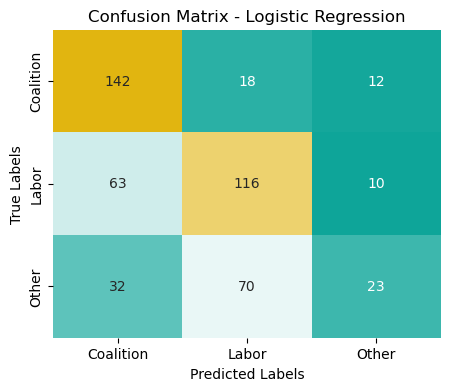

In [35]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_adjusted_final)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cbar=False, cmap=custom_cmap, 
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

Note: Model is misclassifying most of Other voters as Labor voters. Misclassified Labor voters get labelled as Coalition more often than Other. And the model is better at classifying Coalition voters.

While the multinomial logistic regression model proved highly interpretable and offered meaningful insight into the policy and demographic factors distinguishing voter segments, its predictive performance was limited. The model achieved an overall accuracy of 58%, with strong recall for Coalition voters but very low recall for Other party voters, indicating difficulty in identifying these more diverse, less structured preferences. The model's value lies primarily in its explanatory power rather than its predictive accuracy.

## 4.2. Model 2: Random Forest Classifier
Assumptions:
- Dataset is large and diverse enough for a robust and accurate ensemble of trees
- Features do not have strong multicollinearity
- There are complex, non-linear relationships between features and target variable
- Each observation is independent of the others
- Noise in the data is randomly distributed

In [36]:
# Initiate a random forest regressor
rf = RandomForestClassifier(random_state=42, 
                            class_weight="balanced")

# hyperparameter for tuning
param_grid = {
    'n_estimators': [9, 13, 35, 55, 99], #number of trees in the forest
    'criterion': ['gini'], #the function to measure the quality of a split.
    'max_depth': [None, 3, 5, 7], #maximum depth of the tree
    'min_samples_split': [5, 11, 15], #minimum number of samples required to split an internal node
    'min_samples_leaf': [3, 5, 9], #minimum number of samples required to be at a leaf node
    "max_features": ["log2", "sqrt"]
}
# perform grid serach with 5-fold cross-validation
grid_search = GridSearchCV(rf, param_grid, cv=cv, scoring='f1_weighted', verbose=0, n_jobs=3)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=3,
             param_grid={'criterion': ['gini'], 'max_depth': [None, 3, 5, 7],
                         'max_features': ['log2', 'sqrt'],
                         'min_samples_leaf': [3, 5, 9],
                         'min_samples_split': [5, 11, 15],
                         'n_estimators': [9, 13, 35, 55, 99]},
             scoring='f1_weighted')

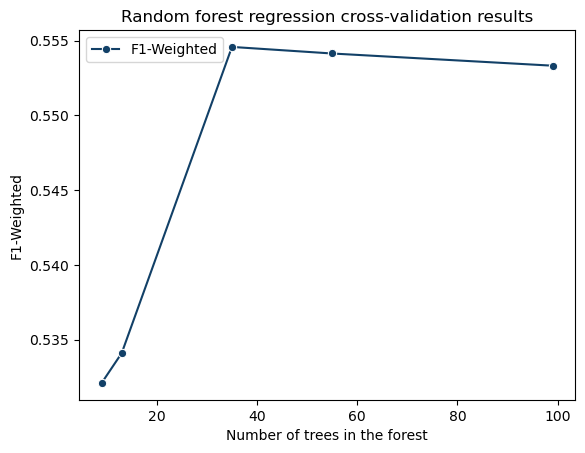

In [37]:
cv_results = pd.DataFrame(grid_search.cv_results_)

# Sort by Mean Test Score
cv_results = cv_results.sort_values(by="mean_test_score", ascending=False)

# Plot Validation Score vs. Hyperparameters

sns.lineplot(x=cv_results['param_n_estimators'].unique()[::-1], 
            y=cv_results['mean_test_score'].groupby(cv_results['param_n_estimators']).mean(), 
            marker='o', label="F1-Weighted", color=custom_palette[0])
plt.xlabel("Number of trees in the forest")
plt.ylabel("F1-Weighted")
plt.title("Random forest regression cross-validation results")
plt.legend()
plt.show()

In [38]:
# best model from grid search
best_rf = grid_search.best_estimator_
best_rf

RandomForestClassifier(class_weight='balanced', max_features='log2',
                       min_samples_leaf=3, min_samples_split=15,
                       n_estimators=99, random_state=42)

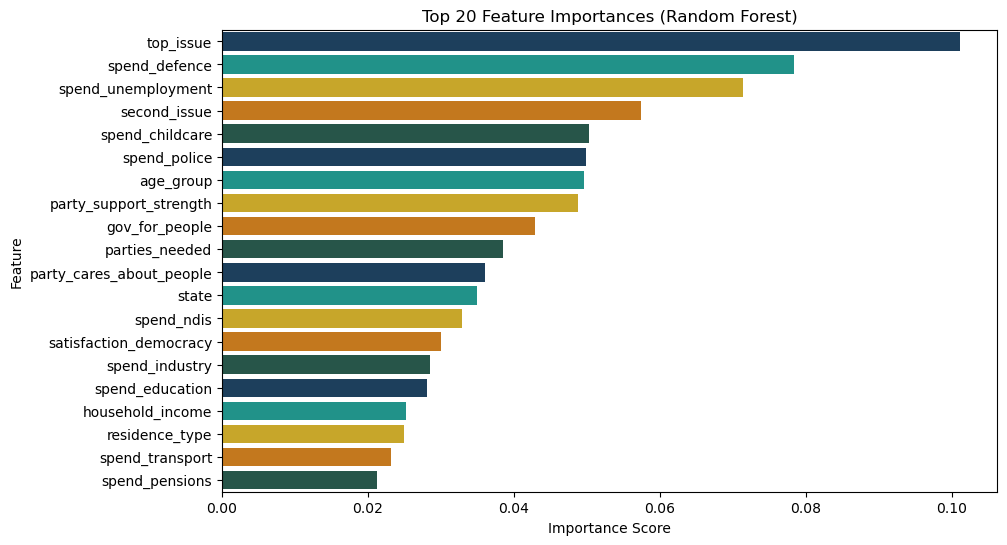

In [39]:
# Get feature importance scores from the Random Forest model
rf_feature_importance = best_rf.feature_importances_

# Create a DataFrame for better visualization
rf_feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_feature_importance
}).sort_values(by='Importance', ascending=False)

# Plot the top 20 most important features
plt.figure(figsize=(10, 6))
sns.barplot(
    x='Importance', 
    y='Feature', 
    data=rf_feature_importance_df.head(20), 
    palette=sns.color_palette(custom_palette, 20),  # Use a built-in palette with 20 colors
    hue='Feature',
    legend=False
)

plt.title('Top 20 Feature Importances (Random Forest)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

Note: The Random Forest model highlighted some of the same top features as the logistic regression model — notably spend_defence, spend_police, and spend_unemployment — but placed a much higher importance on top_issue and second_issue, which were less influential in the logistic regression. This divergence likely reflects the non-linear nature of decision trees and their ability to leverage hierarchical splits and interactions between variables. Unlike logistic regression, Random Forest does not assume a linear relationship between features and the outcome, which may explain why it identified different predictors as being more informative.

## 4.2.1. Model 2 Evaluation

In [40]:
# Evaluate the model with the best parameters
ypred_rf = best_rf.predict(X_test)
class_report = classification_report(y_test, ypred_rf, target_names=class_labels)
print("Classification Report (Random Forest):\n")
print(class_report)

Classification Report (Random Forest):

              precision    recall  f1-score   support

   Coalition       0.63      0.73      0.68       172
       Labor       0.63      0.52      0.57       189
       Other       0.52      0.55      0.53       125

    accuracy                           0.60       486
   macro avg       0.59      0.60      0.59       486
weighted avg       0.60      0.60      0.60       486



Note: The Random Forest model shows slightly better precision but slightly lower recall for both Labor and Coalition voters compared to logistic regression. However, it performs significantly better at identifying Other voters, achieving a recall of 55% (compared to 18% in the logistic model). This suggests that Random Forest is more effective at capturing the subtle patterns that distinguish Other voters from Labor voters — something the linear model struggled with. With an overall accuracy of 60%, Random Forest slightly outperforms logistic regression, though the predictive power remains limited. That said, it provides a more balanced classification across the three voter groups, indicating improved generalizability.

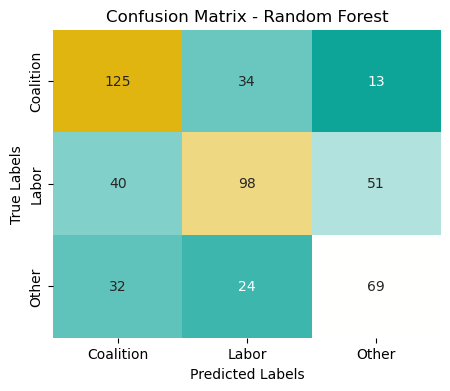

In [41]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, ypred_rf)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cbar=False, cmap=custom_cmap, 
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

Note: This model tends to misclassify Coalition voters as Labor voters, whilst most of the misclassified Labor voters are tagged as Other. Consistent with the classification report, the confusion matrix shows most of the voters that Linear regression misclassified as Labor are correctly classified as Other by the Random Forest.

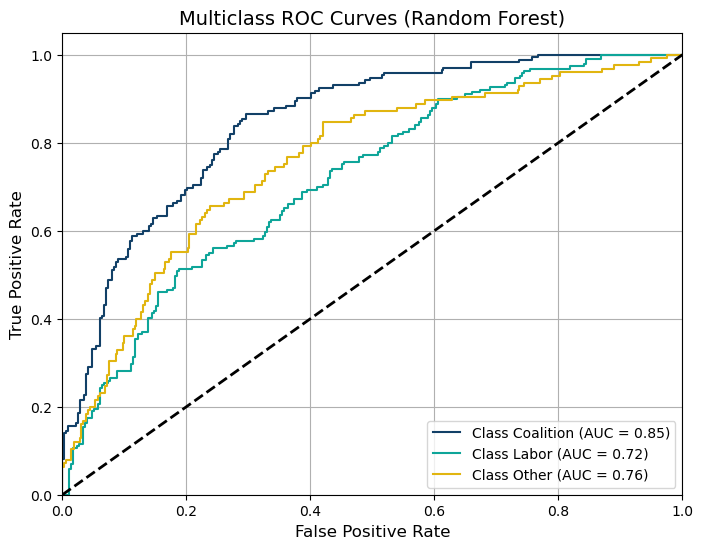

In [42]:
# predicted test probability for all clases:
y_pred_prob_all_rf = pd.DataFrame(best_rf.predict_proba(X_test), columns=['Coalition_pp', 'Labor_pp', 'Other_pp'])

# Binarize the true labels for each class
classes = best_rf.classes_  # Get the class labels
y_test_bin = label_binarize(y_test, classes=classes)  # Binarize the true labels

# Plot ROC curves for each class
plt.figure(figsize=(8, 6))
for i, class_label in enumerate(class_labels):
    # Compute ROC curve and AUC for the current class
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob_all_rf.iloc[:, i])
    roc_auc = auc(fpr, tpr)
    
    # Plot the ROC curve
    plt.plot(fpr, tpr, label=f"Class {class_label} (AUC = {roc_auc:.2f})",
             color=custom_palette[i])

# Plot the diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', linewidth=2)

# Add labels, title, and legend
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Multiclass ROC Curves (Random Forest)', fontsize=14)
plt.legend(loc="lower right")
plt.grid()
plt.show()

Note: The Random Forest classifier has better class separability than Linear Regression for both the Coalition and Other, and has similar class separability for Labor.

The optimised Random Forest classifier was selected for its robustness to multicollinearity and its ability to handle mixed-type features, making it well-suited for survey-based datasets. The model achieved an overall accuracy of 60%, with class-wise F1 scores of 0.68 for Coalition, 0.57 for Labor, and 0.53 for Other. Notably, the model showed a substantial improvement in identifying Other voters compared to logistic regression, with a recall of 55% versus 18%, suggesting a better ability to capture the more nuanced distinctions between Other and Labor voters. ROC AUC scores further supported this, with values of 0.85 for Coalition, 0.72 for Labor, and 0.76 for Other, indicating moderate to strong separability, especially for Coalition voters. While the overall predictive performance remains limited, the Random Forest model offered the most balanced classification across the three voter groups, and its feature importances continue to provide valuable support for the interpretive insights derived from logistic regression.

## 4.3. Model 3: XGB Booster
Assumptions:
- Encoded integer values for each input variable have an ordinal relationship
- Data may have missing values

In [43]:
# Encode the target variable to 0, 1, 2
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)  # Transform y_train to start from 0
y_test_encoded = le.transform(y_test)       # Apply the same transformation to y_test

# Define the parameter grid
param_grid = {
    'n_estimators': [20, 50, 60],  # Number of trees
    'learning_rate': [0.15, 0.2, 0.25],  # Step size shrinkage
    'max_depth': [3, 5],  # Maximum depth of a tree
    'subsample': [0.7, 0.8],  # Fraction of samples used for training each tree
    'colsample_bytree': [0.6],  # Fraction of features used for each tree
    'gamma': [1],  # Minimum loss reduction required for a split
    'reg_alpha': [1],  # L1 regularization term
    'reg_lambda': [2]  # L2 regularization term
}

# Initialize the XGBClassifier
xgb = XGBClassifier(random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='f1_weighted',  # Use an appropriate scoring metric
    cv=cv,  # 5-fold cross-validation
    verbose=1,
    n_jobs=3  
)

# Fit GridSearchCV on the training data
grid_search.fit(X_train, y_train_encoded)

# Get the best parameters and the best model
best_params = grid_search.best_params_
best_xgb = grid_search.best_estimator_

print("Best Parameters:", best_params)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters: {'colsample_bytree': 0.6, 'gamma': 1, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 50, 'reg_alpha': 1, 'reg_lambda': 2, 'subsample': 0.8}


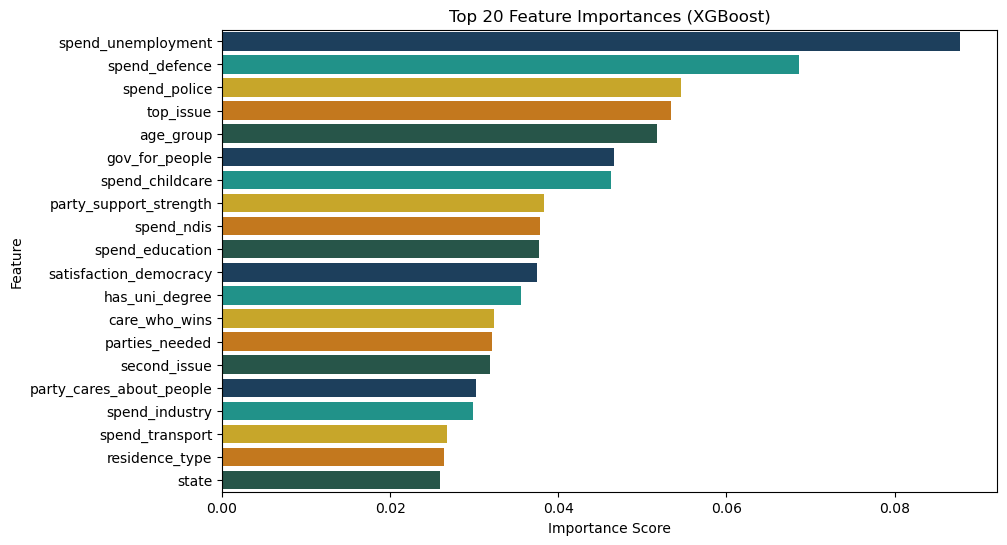

In [44]:
# Get feature importance scores from the XGBoost model
feature_importance = best_xgb.feature_importances_

# Create a DataFrame for better visualization
xgb_feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# Plot the top 20 most important features
plt.figure(figsize=(10, 6))
sns.barplot(
    x='Importance', 
    y='Feature', 
    data=xgb_feature_importance_df.head(20), 
    palette=sns.color_palette(custom_palette, 20),  # Use the same palette
    hue='Feature',
    legend=False
)

plt.title('Top 20 Feature Importances (XGBoost)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

Note: the XGBoost model ranked the same three features as logistic regression among its top predictors — though in a different order — suggesting agreement on the core drivers of voting intention across models. However, XGBoost also placed greater emphasis on top_issue, similarly to Random Forest, indicating that ensemble tree methods are better able to exploit categorical variables like issue rankings and uncover complex interactions that linear models may overlook. Interestingly, XGBoost did not consider second_issue as important as Random Forest did, suggesting that the importance of secondary concerns may be model-dependent and tied to how feature interactions are handled.

## 4.3.1. Model 3 Evaluation

In [45]:
# Evaluate the model with the best parameters
ypred_xgb = best_xgb.predict(X_test)

class_report = classification_report(y_test_encoded, ypred_xgb, zero_division=0, target_names=class_labels)

# Print the classification_report   
print("classification report (XGB Booster):\n")
print(class_report)

classification report (XGB Booster):

              precision    recall  f1-score   support

   Coalition       0.68      0.69      0.69       172
       Labor       0.57      0.61      0.59       189
       Other       0.55      0.49      0.52       125

    accuracy                           0.61       486
   macro avg       0.60      0.60      0.60       486
weighted avg       0.61      0.61      0.61       486



Note: After hyperparameter tuning, the XGBoost classifier showed a marginal improvement over the Random Forest model. It achieved an overall accuracy of 61%, with slightly better precision for Coalition and Other voters, though at a minor cost to recall. For Labor, the trade-off was reversed — showing slightly improved recall but slightly lower precision. The performance remains balanced across all three classes, with F1 scores of 0.69 for Coalition, 0.59 for Labor, and 0.52 for Other.

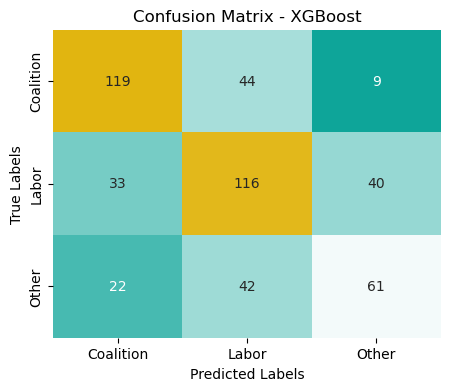

In [46]:
# Decode the predictions back to the original labels
ypred_xgb_decoded = le.inverse_transform(ypred_xgb)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, ypred_xgb_decoded)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cbar=False, cmap=custom_cmap, 
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

Note: The XGBoost model classifies Labor voters with similar accuracy to logistic regression, but the pattern of misclassification differs — XGBoost tends to misclassify Labor voters as Other, whereas logistic regression misclassified them more often as Coalition. Notably, XGBoost is also more effective than Random Forest at distinguishing Other voters from Coalition voters, as seen in the lower number of Other voters misclassified as Coalition (22 vs. 32 in RF). This reflects a better separation of less traditional voter segments, which has been one of the most challenging aspects of the task.

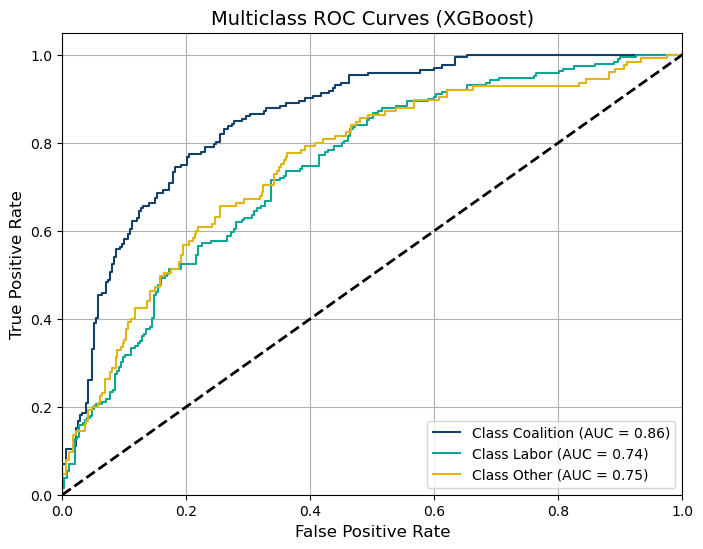

In [47]:
# Predicted test probabilities for all classes
y_pred_prob_all_xgb = pd.DataFrame(best_xgb.predict_proba(X_test), columns=['Coalition_pp', 'Labor_pp', 'Other_pp'])

# Binarize the true labels for each class
classes = best_xgb.classes_  # Get the class labels
y_test_bin = label_binarize(y_test_encoded, classes=range(len(class_labels)))  # Binarize the true labels

# Plot ROC curves for each class
plt.figure(figsize=(8, 6))
for i, class_label in enumerate(class_labels):
    # Compute ROC curve and AUC for the current class
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob_all_xgb.iloc[:, i])
    roc_auc = auc(fpr, tpr)
    
    # Plot the ROC curve
    plt.plot(fpr, tpr, label=f"Class {class_label} (AUC = {roc_auc:.2f})",
             color=custom_palette[i])

# Plot the diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', linewidth=2)

# Add labels, title, and legend
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Multiclass ROC Curves (XGBoost)', fontsize=14)
plt.legend(loc="lower right")
plt.grid()
plt.show()

Note: The tuned XGBoost classifier delivered the best overall performance among all models tested. It achieved an accuracy of 61%, with balanced F1 scores across the three classes: 0.69 for Coalition, 0.59 for Labor, and 0.52 for Other. Notably, it showed improved ability to distinguish Other voters from Coalition voters, a challenge for earlier models. Its ROC AUC scores further confirmed its strength in probabilistic separation, with 0.86 for Coalition, 0.74 for Labor, and 0.75 for Other — the highest or nearly highest across all models. While the ROC curves were the closest to the ideal diagonal, the classifier still exhibited a tendency to misclassify Labor voters as Other and vice versa. These results reinforce that although XGBoost captures more complex patterns in the data and offers marginal gains in accuracy and separability, its performance is still not strong enough to serve as a reliable voter prediction tool. Like the other models, it is more useful for segmenting and understanding voter tendencies than for confidently predicting individual outcomes.

# 5. Final Analysis and Insights

## 5.1. Model Comparison
I compared three models in total: logistic regression, random forest, and XGBoost. Logistic regression was the easiest to interpret and helped explain how things like policy preferences and demographics relate to how people vote. However, even after tuning thresholds, it didn’t perform very well at predicting individual votes — especially for people voting for “Other” parties. Random forest did a better job picking up on more subtle patterns, like identifying Other voters, but the overall accuracy was still about the same. XGBoost came out on top, with the best accuracy at 61%, and the most balanced results across the three classes. It also had the best AUC scores, particularly for Coalition voters. That said, even the best models had limited predictive power, which shows just how complex voting behavior really is. The tree-based models were better at working with the categorical data and capturing patterns that logistic regression missed, but they came at the cost of interpretability.

## 5.2. Key Observations
Looking at both clustering and prediction side by side gave a fuller picture of how people vote. The clustering analysis showed clear voter segments — like older, lower-income rural voters leaning Coalition, and younger, more educated city-based voters leaning Labor or Other. These same patterns showed up again in the predictive models. Features like age_group, social_class, top_issue, and the different spend_ variables were all strong predictors. The logistic model helped explain broad ideological divides, while random forest and XGBoost did a better job at teasing out the fuzzier “Other” group. What was interesting is that the tree-based models gave more importance to variables like top_issue, which logistic regression didn’t rank as highly — probably because they can pick up on more complex patterns and interactions. Overall, both the clustering and the modelling agreed on a few big-picture patterns, even though predicting exactly how someone will vote turned out to be really difficult.

## 5.3. Conclusion
This project showed how useful data science can be for exploring political survey data — even though predicting individual votes isn’t easy. The clustering analysis helped uncover meaningful groups of voters, and the models helped confirm which features really shape people’s choices. But even with advanced models like XGBoost, accuracy never went much higher than 61%, which suggests there are limits to what we can learn from survey data alone. Still, combining clustering with supervised modelling gave a much clearer picture than using either on its own. Logistic regression produced interpretable results, and tree-based models picked up on more complex patterns. While none of these models could predict the vote with high confidence, they were still great tools for understanding how different voters think — which in itself is a valuable insight.

